# TikTok Analysis

In [116]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import pickle

In [2]:
pd.set_option('display.max_colwidth', None)
data_desc = pd.read_csv('dataset_desc.csv')
data_desc

,column_name,data_type,description
0,id,int,Unique identifier for each row in the dataset
1,claim_status,string,Specifies whether the video contains a claim or an opinion
2,video_id,int,Unique numeric identifier assigned to the video
3,video_duration_sec,int,Duration of the video measured in seconds
4,video_transcription_text,string,Text transcription of the video
5,verified_status,string,Indicates whether the video claim has been verified
6,author_ban_status,string,Shows the current ban status of the video's author
7,video_view_count,float,Total number of views the video has received
8,video_like_count,float,Total number of likes the video has received
9,video_share_count,float,Total number of times the video has been shared


**What is a "claim" vs an "opinion"?**

In this dataset, each TikTok video is labeled based on the type of statement it contains:
- Claim: A verifiable factual statement that can be evaluated as true or false. Claims typically reference measurable data, historical events, or real-world facts.
Example: "GDP increased by 5% in 2023."
- Opinion: A subjective statement reflecting personal beliefs, preferences, or emotions. Opinions cannot be objectively verified.
Example: "I think TikTok is the best app."

This distinction is important for fact-checking tasks and content analysis, as only claims can be assessed for factual accuracy.

Labeling helps identify which videos can be fact-checked (claims) and which are purely subjective (opinions). This supports misinformation detection, content analysis, and understanding how users interact with different types of information.

## Data cleaning and overview

In [3]:
data = pd.read_csv('tiktok_dataset.csv')
df = data.copy()
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries are already happening and will become common by 2025,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more microorganisms in one teaspoon of soil than people on the planet,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,"someone shared with me that american industrialist andrew carnegie had a net worth of $475 million usd, worth over $300 billion usd today",not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,"someone shared with me that the metro of st. petersburg, with an average depth of hundred meters, is the deepest metro in the world",not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of businesses allowing employees to bring pets to the workplace has grown by 6% worldwide,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [4]:
df.size

232584

In [5]:
df.shape

(19382, 12)

In [6]:
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


The dataset contains 19,382 TikTok videos.

Average video length is about 32 seconds, with most between 18 and 47 seconds.

Engagement metrics like views, likes, shares, downloads, and comments are highly skewed - a few videos have extremely high values.

Median values are much lower than the means, showing that most videos get relatively low engagement.

Some videos have zero interactions, while others reach hundreds of thousands of likes and shares.

In [7]:
df.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [8]:
df = df.dropna(axis=0)

Removing Rows with Missing Data

298 rows contain missing values in key engagement and transcription fields. These rows are removed to ensure accurate analysis and avoid skewed results.

#### Claim vs Opinion

In [9]:
df['claim_status'].value_counts()

claim_status
claim      9608
opinion    9476
Name: count, dtype: int64

In [10]:
video_count_cols = ['video_view_count', 'video_like_count', 'video_comment_count', 
                    'video_share_count', 'video_download_count']
claims = df[df['claim_status'] == 'claim']
opinions = df[df['claim_status'] == 'opinion']
claim_opinion_comparison = {
    'Column' : [],
    'Claim_Mean' : [],
    'Opinion_Mean' : [],
    'Claim_Median' : [],
    'Opinion_Median' : [],
}
for col in video_count_cols:
    claim_opinion_comparison['Column'].append(col)
    claim_opinion_comparison['Claim_Mean'].append(claims[col].mean())
    claim_opinion_comparison['Opinion_Mean'].append(opinions[col].mean())
    claim_opinion_comparison['Claim_Median'].append(claims[col].median())
    claim_opinion_comparison['Opinion_Median'].append(opinions[col].median())

claim_opinion_comparison = pd.DataFrame(claim_opinion_comparison)
claim_opinion_comparison

,Column,Claim_Mean,Opinion_Mean,Claim_Median,Opinion_Median
0,video_view_count,501029.452748,4956.432250,501555.0,4953.0
1,video_like_count,166373.331182,1092.729844,123649.0,823.0
2,video_comment_count,691.164863,2.697446,286.0,1.0
3,video_share_count,33026.416216,217.145631,17997.5,121.0
4,video_download_count,2070.952227,13.677290,1139.5,7.0


The table above compares the average (mean) and median for TikTok videos labeled as claims versus opinions. The metrics include view, like, share, download, and comment counts.

Claim videos get much more engagement than opinion videos - more views, likes, shares, downloads, and comments.
Opinion videos have much lower numbers, which means people interact with them less.
This suggests that videos that sound factual get more attention on TikTok.

#### Engagement by Claim Type and Author Ban Status

In [11]:
df.groupby(['claim_status', 'author_ban_status']).count()[['#']]

#
claim_status author_ban_status      
claim        active             6566
             banned             1439
             under review       1603
opinion      active             8817
             banned              196
             under review        463

In [12]:
df.groupby(['author_ban_status']).agg({
    'video_view_count' : ['mean', 'median'], 
    'video_like_count' : ['mean', 'median'],
    'video_comment_count' : ['mean', 'median'],
    'video_share_count' : ['mean', 'median'], 
    'video_download_count' : ['mean', 'median'] 
}).round(3)

video_view_count           video_like_count            \
                              mean    median             mean    median   
author_ban_status                                                         
active                  215927.040    8616.0        71036.534    2222.0   
banned                  445845.439  448201.0       153017.237  105573.0   
under review            392204.836  365245.5       128718.050   71204.5   

                  video_comment_count        video_share_count           \
                                 mean median              mean   median   
author_ban_status                                                         
active                        295.134    5.0         14111.466    437.0   
banned                        614.957  209.0         29998.943  14468.0   
under review                  542.481  136.5         25774.697   9444.0   

                  video_download_count         
                                  mean median  
author_ban_status                              
active                         882.276   28.0  
banned                        1886.296  892.0  
under review                  1631.735  610.5

Number of engagement metric per view:

In [13]:
for col in video_count_cols[1:]:
    df[col+'_per_view'] = df[col] / df['video_view_count']

In [14]:
df.groupby(['author_ban_status','claim_status']).agg(
    {col: ['count', 'mean', 'median'] for col in video_count_cols[1:]}).round(3)

video_like_count                        \
                                          count        mean    median   
author_ban_status claim_status                                          
active            claim                    6566  164960.303  121943.0   
                  opinion                  8817    1091.715     820.0   
banned            claim                    1439  173719.103  132044.0   
                  opinion                   196    1027.515     799.5   
under review      claim                    1603  165566.954  125882.0   
                  opinion                   463    1139.663     876.0   

                               video_comment_count                  \
                                             count     mean median   
author_ban_status claim_status                                       
active            claim                       6566  687.828  286.0   
                  opinion                     8817    2.697    1.0   
banned            claim                       1439  698.402  296.0   
                  opinion                      196    2.311    1.0   
under review      claim                       1603  698.336  279.0   
                  opinion                      463    2.877    1.0   

                               video_share_count                      \
                                           count       mean   median   
author_ban_status claim_status                                         
active            claim                     6566  32769.102  17774.5   
                  opinion                   8817    217.167    121.0   
banned            claim                     1439  34056.581  19018.0   
                  opinion                    196    208.423    108.5   
under review      claim                     1603  33155.623  18084.0   
                  opinion                    463    220.432    124.0   

                               video_download_count                    
                                              count      mean  median  
author_ban_status claim_status                                         
active            claim                        6566  2048.670  1124.5  
                  opinion                      8817    13.666     7.0  
banned            claim                        1439  2141.458  1204.0  
                  opinion                       196    12.939     6.0  
under review      claim                        1603  2098.931  1153.0  
                  opinion                       463    14.205     8.0

The analysis compares engagement metrics across different combinations of claim_status (claim vs opinion) and author_ban_status (active, banned, under review). 

Key observations:
- Claim videos get much more engagement than opinions - more views, likes, shares, comments, and downloads.
- Banned or under review authors tend to have higher engagement, especially for claims.
- The highest interaction comes from claim videos by banned users.
- Opinion videos from active users show the lowest engagement, both in means and medians.

## Data visualizations

Export dataset for visualizations in Tableau

In [15]:
df.to_csv('tiktok_cleaned.csv', index=False)

Tableau dashboard: https://public.tableau.com/views/TikTokAnalysis_17494551128290/Dashboard1?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

The spread of values in `video_duration_sec`:

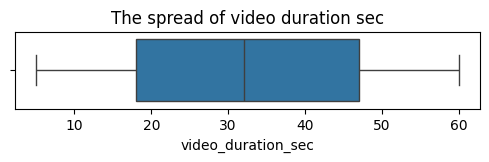

In [16]:
plt.figure(figsize=(6,1))
plt.title('The spread of video duration sec')
sns.boxplot(x=df['video_duration_sec'])
plt.show()

Distribution of `video_duration_sec` - all videos are 5-60 seconds long and the distribution is uniform:

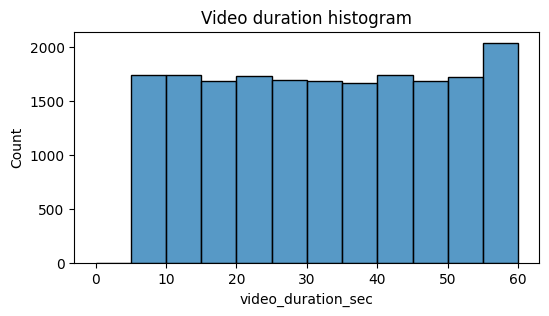

In [17]:
plt.figure(figsize=(6,3))
sns.histplot(df['video_duration_sec'], bins=range(0,61,5))
plt.title('Video duration histogram')
plt.show()

#### Engagement Distribution Boxplots and Histograms

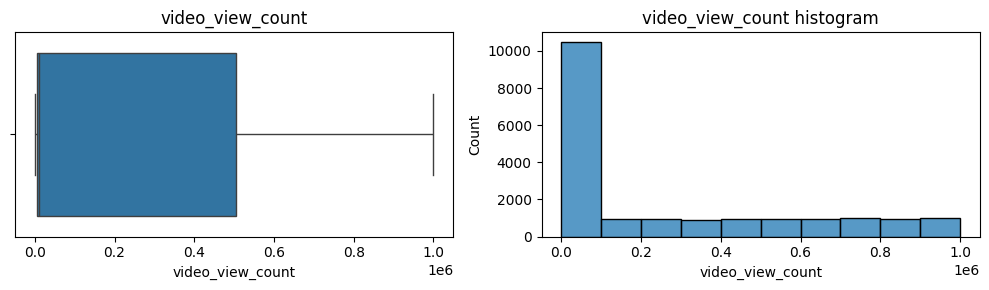

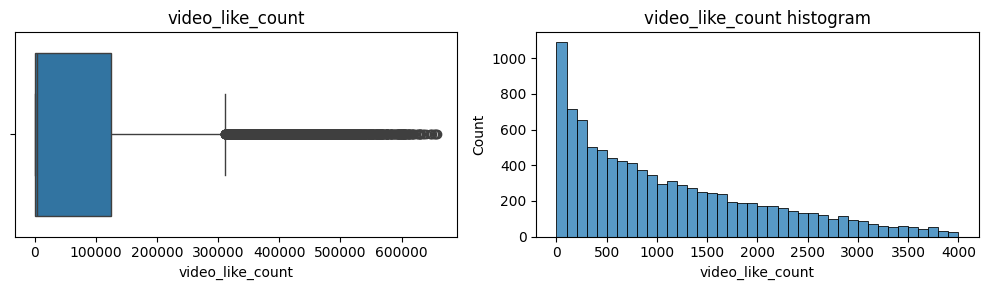

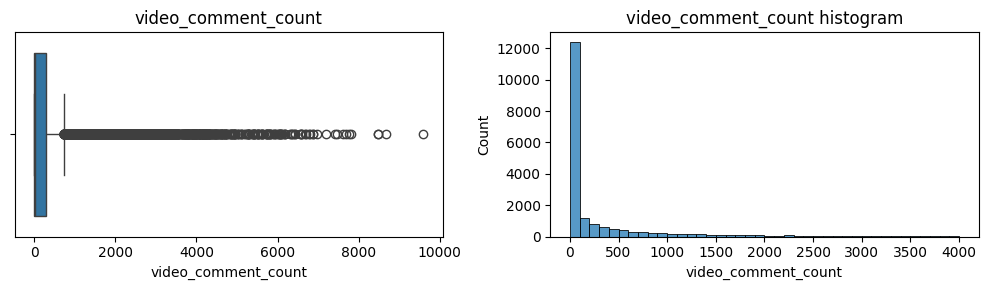

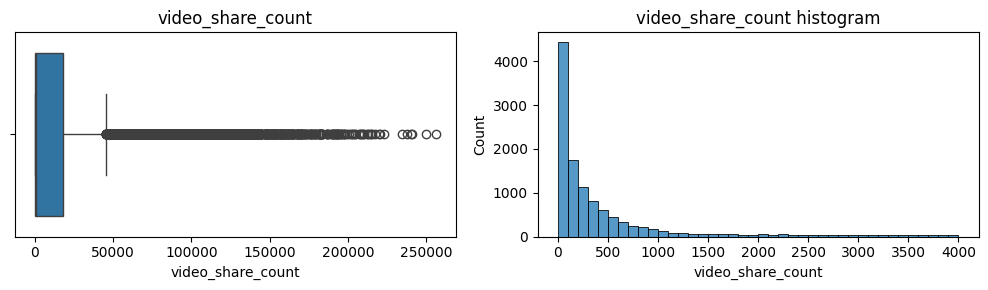

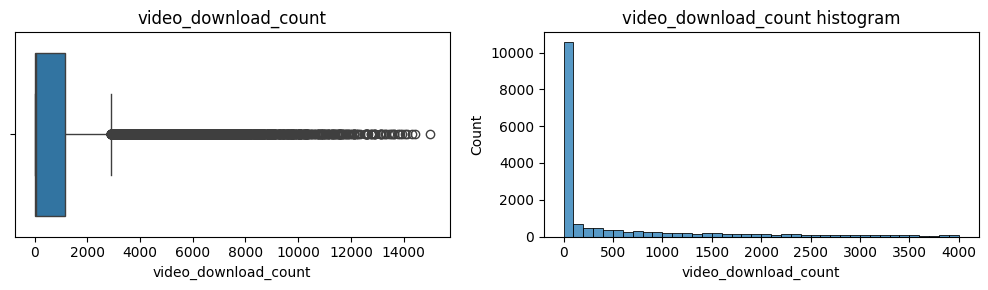

In [18]:
for col in video_count_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10,3))

    sns.boxplot(x=df[col], ax=axes[0])
    axes[0].set_title(col)

    if col == 'video_view_count':
        bins = range(0,(10**6+1),10**5)
    else:
        bins = range(0,(4001),100)
        
    sns.histplot(df[col], ax=axes[1], bins=bins)
    axes[1].set_title(col+' histogram')

    plt.tight_layout()
    plt.show()

The boxplots and histograms show that all engagement variables (views, likes, comments, shares, downloads) are highly skewed to the right, with a long tail of extremely high values (outliers).
- Outliers are clearly visible in boxplots.
- Histograms show most values are clustered near zero.
- This pattern reflects typical social media dynamics, where few videos get most of the attention.

#### Claim status by verification status

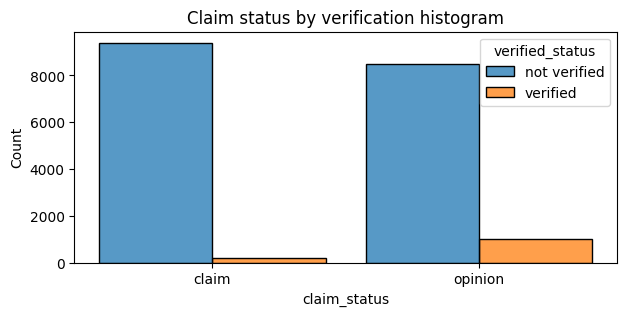

In [19]:
plt.figure(figsize=(7,3))
sns.histplot(data=df, x='claim_status', hue='verified_status', multiple='dodge', shrink=0.85)
plt.title('Claim status by verification histogram')
plt.show()

There are far fewer verified users than unverified users, but if a user is verified, they are much more likely to post opinions.

#### Claim status by author ban status

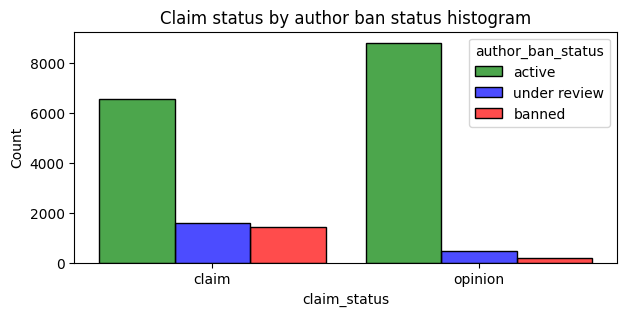

In [20]:
plt.figure(figsize=(7,3))
sns.histplot(data=df, x='claim_status', hue='author_ban_status', hue_order=['active','under review', 'banned'],
             multiple='dodge', shrink=0.85, 
             palette={'active':'green','under review':'blue','banned':'red'}, alpha=0.7)
plt.title('Claim status by author ban status histogram')
plt.show()

For both claims and opinions, there are many more active authors than banned authors or authors under review; however, the proportion of active authors is far greater for opinion videos than for claim videos. Again, it seems that authors who post claim videos are more likely to come under review and/or get banned.

#### Median view count by ban status

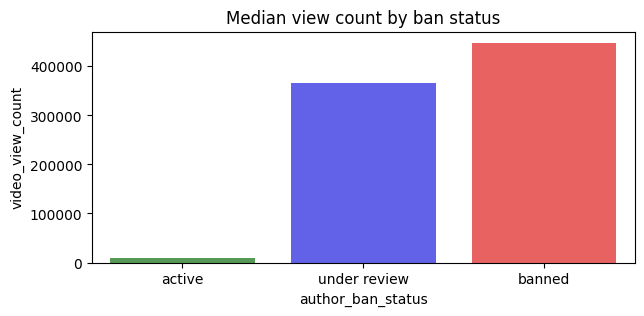

In [21]:
ban_status_count = df.groupby(['author_ban_status']).median(numeric_only=True).reset_index()

plt.figure(figsize=(7,3))
sns.barplot(data=ban_status_count, x='author_ban_status', hue='author_ban_status', y='video_view_count',
           order=['active', 'under review', 'banned'],
           palette={'active':'green','under review':'blue','banned':'red'}, alpha=0.7)
plt.title('Median view count by ban status')
plt.show()

The median view counts for non-active authors are many times greater than the median view count for active authors. Since non-active authors are more likely to post claims, and that videos by non-active authors get far more views on aggregate than videos by active authors, then `video_view_count` might be a good indicator of claim status.

#### Total views by claim status

The overall view count is dominated by claim videos even though there are roughly the same number of each video in the dataset.

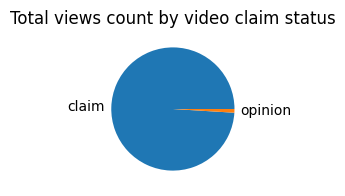

In [22]:
plt.figure(figsize=(2,2))
plt.pie(df.groupby(['claim_status'])['video_view_count'].sum(), labels=['claim', 'opinion'])
plt.title('Total views count by video claim status')
plt.show()

## Determine outliers

In [23]:
print("Number of outliers")
for col in video_count_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    median = df[col].median()
    outlier_threshold = median + 1.5 * iqr
    outlier_count = (df[col] > outlier_threshold).sum()
    print(col, ":", outlier_count)

Number of outliers
video_view_count : 2343
video_like_count : 3468
video_comment_count : 3882
video_share_count : 3732
video_download_count : 3733


This confirms the strongly skewed distribution of the data — a relatively small portion of videos receive exceptionally high engagement compared to the rest.

#### Scatterplots

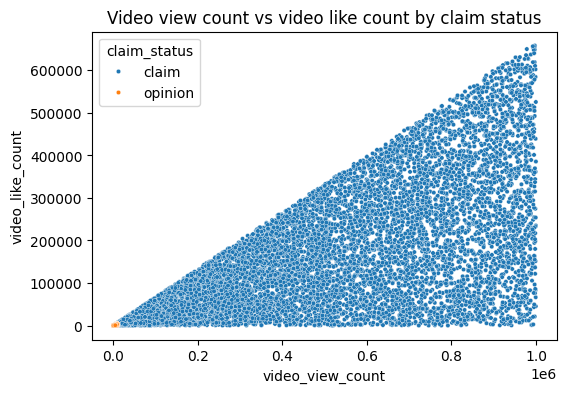

In [24]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['video_view_count'], y=df['video_like_count'], hue=df['claim_status'], s=10)
plt.title('Video view count vs video like count by claim status')
plt.show()

This scatter plot shows the relationship between video view counts and like counts, categorized by `claim_status`. 

- Most videos are labeled as `claim` (blue), while `opinion` videos (orange) are rare and clustered in the lower-left corner.
- Most videos are claims
- More views usually mean more likes
- Opinion videos are few and have low views and likes


## Hypothesis testing

Two-sample t-test

Null hypothesis - there is no difference in number of views bewtween videos posted by verified accounts and posted by unverified accounts.

Alternative hypothesis - there is a difference in a number of views bewtween videos posted by verified accounts and posted by unverified accounts.

Significance level = 5%

In [25]:
df["verified_status"].value_counts(normalize=True)

verified_status
not verified    0.93712
verified        0.06288
Name: proportion, dtype: float64

In [26]:
verified = df[df['verified_status'] == 'verified']['video_view_count']
not_verified = df[df['verified_status'] == 'not verified']['video_view_count']

stats.ttest_ind(b=verified, a=not_verified, equal_var=False)

TtestResult(statistic=np.float64(25.499441780633777), pvalue=np.float64(2.6088823687177823e-120), df=np.float64(1571.163074387424))

P-value is very small (smaller than the significance level), so because of that null hypothesis is rejected. From that it can be conclued that there is a statistically significant difference in the mean video view count between verified and unverified accounts on TikTok.

## Regression modeling

How different variables are associated with weather a user is verified?

If the user is verified, they are much more likely to post opinions. Let's explore how to predict verified status to understand how video characteristics are related to verified users.

Since class is highly imbalanced it's better to use resampling to create this class balance.

In [27]:
df_maj = df[df['verified_status'] == 'not verified']
df_min = df[df['verified_status'] == 'verified']

df_min_upsampled = resample(df_min, replace=True, n_samples=len(df_maj), random_state=42)
df_upsampled = pd.concat([df_maj, df_min_upsampled]).reset_index(drop=True)

df_upsampled['verified_status'].value_counts()

verified_status
not verified    17884
verified        17884
Name: count, dtype: int64

In [28]:
df_upsampled['text_length'] = df_upsampled['video_transcription_text'].apply(func=lambda text: len(text))
df_upsampled.head(3)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,video_like_count_per_view,video_comment_count_per_view,video_share_count_per_view,video_download_count_per_view,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries are already happening and will become common by 2025,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,0.056584,0.000000,0.000702,0.000003,97
1,2,claim,4014381136,32,someone shared with me that there are more microorganisms in one teaspoon of soil than people on the planet,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,0.549096,0.004855,0.135111,0.008241,107
2,3,claim,9859838091,31,"someone shared with me that american industrialist andrew carnegie had a net worth of $475 million usd, worth over $300 billion usd today",not verified,active,902185.0,97690.0,2858.0,833.0,329.0,0.108282,0.000365,0.003168,0.000923,137


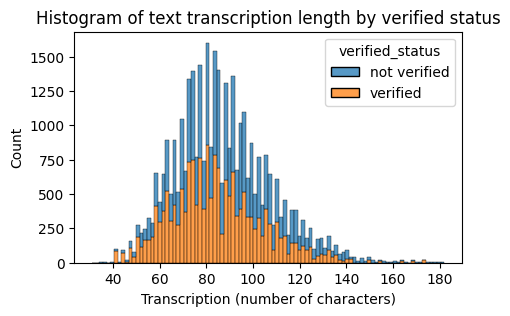

In [29]:
plt.figure(figsize=(5,3))
sns.histplot(data=df_upsampled, stat='count', multiple='stack', x='text_length', 
             hue='verified_status', element='bars', legend=True)
plt.title('Histogram of text transcription length by verified status')
plt.xlabel('Transcription (number of characters)')
plt.ylabel('Count')
plt.show()

#### Correlactions examination

In [30]:
df_upsampled.corr(numeric_only=True)

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,video_like_count_per_view,video_comment_count_per_view,video_share_count_per_view,video_download_count_per_view,text_length
#,1.000000,-0.001369,-0.011800,-0.698969,-0.580705,-0.503634,-0.489758,-0.416835,-0.281526,-0.309297,-0.212315,-0.198069,-0.196817
video_id,-0.001369,1.000000,0.013938,0.001607,0.005167,0.009136,0.006814,0.011346,-0.008550,0.000024,-0.003661,-0.003142,-0.007634
video_duration_sec,-0.011800,0.013938,1.000000,0.013892,0.004610,0.001944,0.006930,-0.000664,-0.004085,-0.017286,-0.003802,0.001828,-0.005043
video_view_count,-0.698969,0.001607,0.013892,1.000000,0.830843,0.710466,0.691557,0.585626,0.270221,0.286045,0.200557,0.175337,0.246867
video_like_count,-0.580705,0.005167,0.004610,0.830843,1.000000,0.851262,0.828637,0.707283,0.566643,0.431083,0.402821,0.364955,0.204647
video_share_count,-0.503634,0.009136,0.001944,0.710466,0.851262,1.000000,0.709738,0.621048,0.481414,0.382555,0.590661,0.313599,0.176362
video_download_count,-0.489758,0.006814,0.006930,0.691557,0.828637,0.709738,1.000000,0.852601,0.471331,0.587743,0.338881,0.567331,0.175287
video_comment_count,-0.416835,0.011346,-0.000664,0.585626,0.707283,0.621048,0.852601,1.000000,0.405240,0.738456,0.304249,0.485306,0.154423
video_like_count_per_view,-0.281526,-0.008550,-0.004085,0.270221,0.566643,0.481414,0.471331,0.405240,1.000000,0.539853,0.675444,0.665899,0.087555
video_comment_count_per_view,-0.309297,0.000024,-0.017286,0.286045,0.431083,0.382555,0.587743,0.738456,0.539853,1.000000,0.389903,0.742480,0.111825


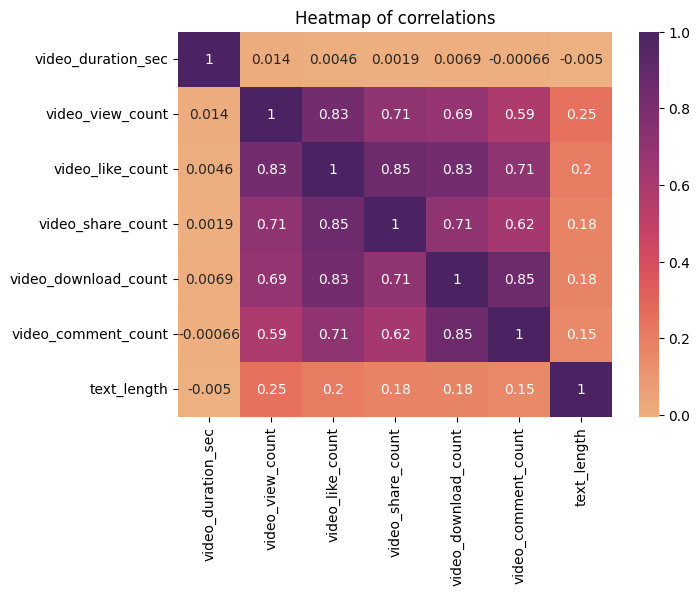

In [31]:
plt.figure(figsize=(7,5))
sns.heatmap(df_upsampled[["video_duration_sec", "claim_status", "author_ban_status", 
                          "video_view_count", "video_like_count", "video_share_count", 
                          "video_download_count", "video_comment_count", "text_length"]]
           .corr(numeric_only=True), annot=True, cmap='flare')
plt.title('Heatmap of correlations')
plt.show()

#### Encoding

In [32]:
X = df_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                  "video_share_count", "video_download_count", "video_comment_count"]]
# 'video_like_count is excluded because it doesn't meet no multicollinearity assumption
y = df_upsampled['verified_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26826, 7), (8942, 7), (26826,), (8942,))

In [33]:
X_train['claim_status'].unique(), X_train['author_ban_status'].unique()

(array(['opinion', 'claim'], dtype=object),
 array(['active', 'banned', 'under review'], dtype=object))

In [34]:
X_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = X_encoder.fit_transform(X_train[['claim_status', 'author_ban_status']])
X_train_encoded_df = pd.DataFrame(data=X_train_encoded, columns=X_encoder.get_feature_names_out())

X_train_final = pd.concat([X_train.drop(columns=['claim_status', 'author_ban_status'])
                           .reset_index(drop=True), X_train_encoded_df], axis=1)

X_train_final.head(3)

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,6,238.0,6.0,0.0,0.0,1.0,0.0,0.0
1,51,5002.0,480.0,12.0,1.0,1.0,0.0,0.0
2,32,2042.0,145.0,11.0,3.0,1.0,0.0,0.0


In [35]:
X_test_encoded = X_encoder.transform(X_test[['claim_status', 'author_ban_status']])
X_test_encoded_df = pd.DataFrame(data=X_test_encoded, columns=X_encoder.get_feature_names_out())

X_test_final = pd.concat([X_test.drop(columns=['claim_status', 'author_ban_status'])
                         .reset_index(drop=True), X_test_encoded_df], axis=1)

X_test_final.head(3)

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,27,519.0,65.0,1.0,0.0,1.0,0.0,0.0
1,60,7539.0,181.0,0.0,0.0,1.0,0.0,0.0
2,59,5129.0,179.0,2.0,0.0,1.0,0.0,0.0


In [36]:
y_train.unique()

array(['verified', 'not verified'], dtype=object)

In [37]:
y_encoder = OneHotEncoder(drop='first', sparse_output=False)

y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()
# shape has to be adjusted before fit_transform since it takes place in 2D array
# ravel - to flatten the array returnet by fit_transform so it can be used to train the model

In [38]:
y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

In [39]:
X_train_final.shape, y_train_final.shape, X_test_final.shape, y_test_final.shape

((26826, 8), (26826,), (8942, 8), (8942,))

In [40]:
log_clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train_final, y_train_final)

y_pred = log_clf.predict(X_test_final)

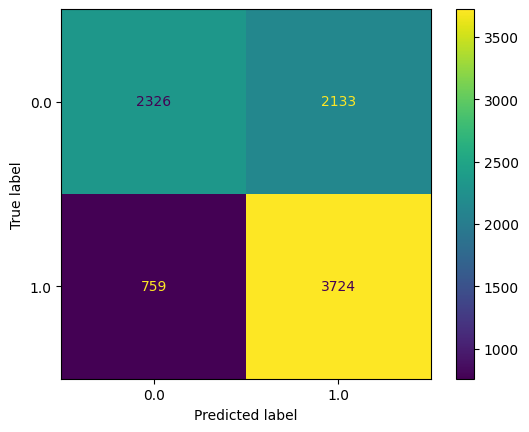

In [41]:
log_cm = confusion_matrix(y_test_final, y_pred)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)
log_disp.plot()
plt.show()

In [42]:
print(classification_report(y_test_final, y_pred, target_names=['verified', 'not verified']))

              precision    recall  f1-score   support

    verified       0.75      0.52      0.62      4459
not verified       0.64      0.83      0.72      4483

    accuracy                           0.68      8942
   macro avg       0.69      0.68      0.67      8942
weighted avg       0.69      0.68      0.67      8942



In [43]:
pd.DataFrame(data={
    'Feature name' : log_clf.feature_names_in_,
    'Model coefficient' : log_clf.coef_[0]
}).round(6)

,Feature name,Model coefficient
0,video_duration_sec,-0.001723
1,video_view_count,-0.000000
2,video_share_count,0.000005
3,video_download_count,-0.000180
4,video_comment_count,0.000275
5,claim_status_opinion,1.636664
6,author_ban_status_banned,-0.429341
7,author_ban_status_under review,-0.127500


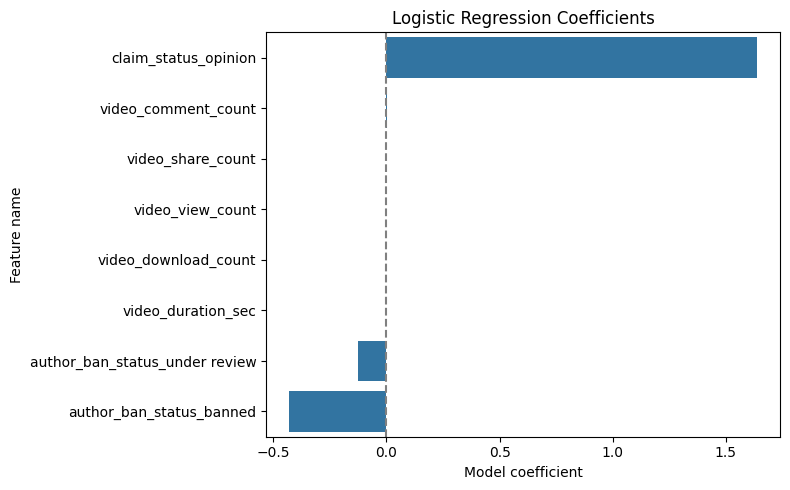

In [44]:
coefs = pd.DataFrame(data={
    'Feature name' : log_clf.feature_names_in_,
    'Model coefficient' : log_clf.coef_[0]
}).sort_values('Model coefficient', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=coefs, x='Model coefficient', y='Feature name')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Logistic Regression Coefficients')
plt.tight_layout()
plt.show()

Logistic Regression Summary

The logistic regression model was trained to predict whether an account is verified based on video characteristics and author status.
- Accuracy: 0.68
- The model performs slightly better at identifying not verified accounts (recall = 0.83) than verified ones (recall = 0.52).
- This suggests the model is better at detecting typical, non-verified behavior than rare, verified patterns.
- `claim_status_opinion` has the strongest positive impact, meaning that posting opinions is strongly associated with non-verified accounts.
- `author_ban_status_` banned and under review have negative coefficients, indicating that these statuses are linked to non-verified accounts.
- Most numeric video metrics (like `video_view_count`, `video_view_likes`, etc.) have very small weights, meaning they play a minor role in prediction.

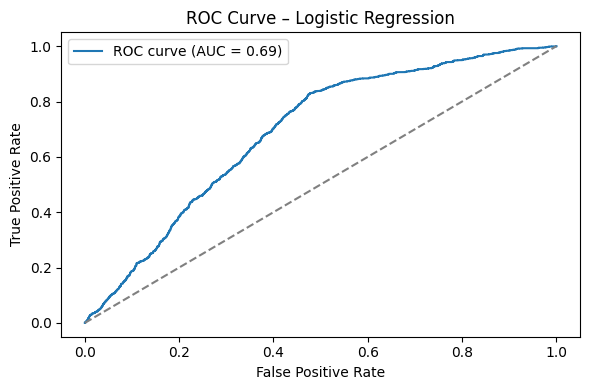

In [45]:
y_probs = log_clf.predict_proba(X_test_final)[:, 1]
fpr, tpr, threshold = roc_curve(y_test_final, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression')
plt.legend()
plt.tight_layout()
plt.show()


The logistic regression model achieved an AUC of 0.69, which indicates moderate ability to distinguish between verified and not verified accounts.

The ROC curve shows a clear improvement over random guessing (diagonal line), though the separation is not perfect.

This suggests the model captures useful patterns, but the classification is still challenging.

In [89]:
log_clf_report = {
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test_final, y_pred),
    'Precision': precision_score(y_test_final, y_pred),
    'Recall': recall_score(y_test_final, y_pred),
    'F1-Score': f1_score(y_test_final, y_pred)
}

pd.Series(log_clf_report).round(5)

Model        Logistic Regression
Accuracy                0.676582
Precision                0.63582
Recall                  0.830694
F1-Score                0.720309
dtype: object

## Random Forest Classifier

The goal is to build a machine learning model that distinguishes between videos making claims and those expressing opinions. This will help TikTok prioritize videos for human moderation by focusing on those more likely to violate the platform's terms of service.

For this model the data will be split into training, validation, and test sets (to result in a final ratio of 60/20/20 for train/validate/test sets).

Recall is the most appropriate evaluation metric in this context because false negatives are more costly than false positives.
- A false negative means the model predicted opinion when the video was actually a claim - and since claims are more likely to violate TikTok’s terms, this means a potentially harmful video could be missed and not reviewed by a human moderator.
- A false positive (predicting a claim when it's really an opinion) just means an opinion video might be unnecessarily reviewed which is less serious.

In [54]:
df_rfc = df.copy()
df_rfc.drop(columns=['video_like_count_per_view','video_share_count_per_view',
                     'video_comment_count_per_view', 'video_download_count_per_view'], inplace=True)
df_rfc['text_length'] = df_rfc['video_transcription_text'].str.len()
df_rfc.head(3)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries are already happening and will become common by 2025,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more microorganisms in one teaspoon of soil than people on the planet,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,"someone shared with me that american industrialist andrew carnegie had a net worth of $475 million usd, worth over $300 billion usd today",not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137


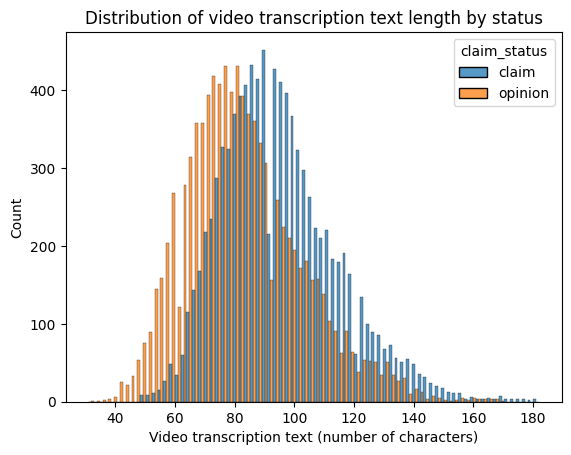

In [56]:
sns.histplot(data=df_rfc, stat='count', multiple='dodge', x='text_length', hue='claim_status')
plt.xlabel('Video transcription text (number of characters)')
plt.title('Distribution of video transcription text length by status')
plt.show()

#### Feature transformation

In [68]:
X = df_rfc.copy()
X = X.drop(['#', 'video_id', 'video_transcription_text'], axis = 1)

X['claim_status'] = X['claim_status'].map({'opinion': 0, 'claim': 1}).astype(int)
X = pd.get_dummies(X, columns=['verified_status', 'author_ban_status'], drop_first=True)

X.head(3)

,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False


In [69]:
y = X['claim_status']
X = X.drop(['claim_status'], axis=1)

# Split to training and testing - 80/20
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data to training and validation - 75/25
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 10), (3817, 10), (3817, 10), (11450,), (3817,), (3817,))

In [75]:
rfc = RandomForestClassifier(random_state=42)

rfc_cv_params = {'max_depth': [3, 5, 7, None],
                 'max_features': [0.6, 0.9],
                 'max_samples': [0.7],
                 'min_samples_leaf': [1,2,3],
                 'min_samples_split': [2,3],
                 'n_estimators': [25,50,100],
                }

rfc_scoring = ['accuracy', 'precision', 'recall', 'f1']

rfc_cv = GridSearchCV(rfc, rfc_cv_params, scoring=rfc_scoring, cv=5, refit='recall')

rfc_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7, None],
                         'max_features': [0.6, 0.9], 'max_samples': [0.7],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [25, 50, 100]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [76]:
print(rfc_cv.best_score_)
print(rfc_cv.best_params_)

0.9917214602362321
{'max_depth': 5, 'max_features': 0.9, 'max_samples': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 25}


In [77]:
y_pred_rfc = rfc_cv.best_estimator_.predict(X_val)

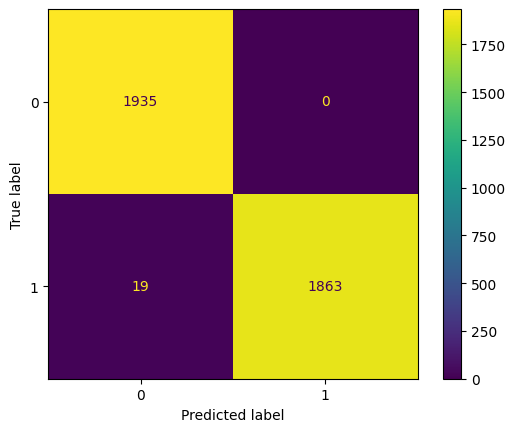

In [79]:
rfc_cm = confusion_matrix(y_val, y_pred_rfc)
rfc_cm_disp = ConfusionMatrixDisplay(confusion_matrix=rfc_cm, display_labels=None)
rfc_cm_disp.plot()
plt.show()

In [80]:
print(classification_report(y_val, y_pred_rfc, target_names=['opinion', 'claim']))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1935
       claim       1.00      0.99      0.99      1882

    accuracy                           1.00      3817
   macro avg       1.00      0.99      1.00      3817
weighted avg       1.00      1.00      1.00      3817



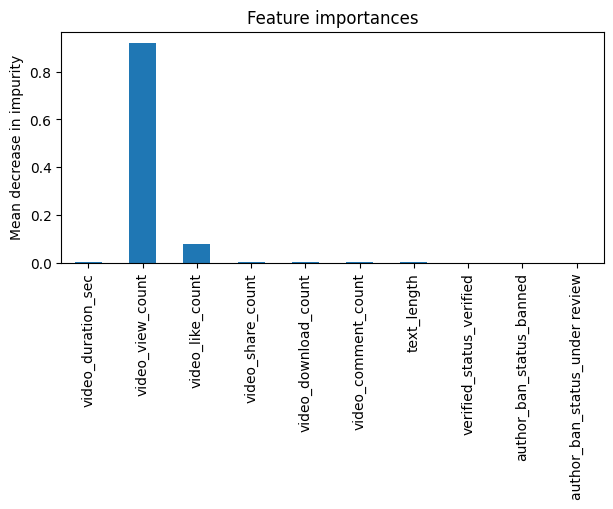

In [114]:
importances_rfc = rfc_cv.best_estimator_.feature_importances_
rfc_importances = pd.Series(importances_rfc, index=X_val.columns)

plt.figure(figsize=(7,3))
rfc_importances.plot.bar()
plt.title('Feature importances')
plt.ylabel('Mean decrease in impurity')
plt.show()

Random Forest Classifier Summary

The Random Forest Classifier performed exceptionally well on the validation set, demonstrating high accuracy and excellent claim identification.

- Claim Detection: The model accurately identified 1863 true claims while missing only 19 (~1%) false negatives. Crucially, it had zero false positives, meaning no opinions were mistakenly classified as claims. This high recall (0.99) is vital for identifying potentially harmful content.
- Overall Performance: Achieved an overall accuracy of 1.00, with precision and F1-scores for claims also at 0.99 or higher.
- Feature Importance: `video_view_count` was by far the most significant predictor. Other features like `video_like_count` and `author_ban_status` under_review had minimal impact. This suggests a strong reliance on video popularity for classification.


In [107]:
models_results = []

rfc_report = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_val, y_pred_rfc),
    'Precision': precision_score(y_val, y_pred_rfc),
    'Recall': recall_score(y_val, y_pred_rfc),
    'F1-Score': f1_score(y_val, y_pred_rfc)
}

models_results.append(rfc_report)
models_results_df = pd.DataFrame(models_results).round(5)
models_results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.99502,1.0,0.9899,0.99493


#### XGboost

XGBoost (Extreme Gradient Boosting) is a powerful and efficient implementation of gradient boosting algorithms.
It is widely used in machine learning competitions and real-world applications due to its high performance, speed, and ability to handle missing values and overfitting.
XGBoost is applied here to classify videos as claims or opinions and compare its performance with other model.

In [99]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)
xgb_cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1, 0.2],
             'n_estimators': [100, 300, 500]
             }
xgb_scoring = ['accuracy', 'precision', 'recall', 'f1']
xgb_cv = GridSearchCV(xgb, xgb_cv_params, scoring=xgb_scoring, cv=5, refit='recall')

xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [4, 8, 12], 'min_child_weight': [3, 5],
                         'n_estimators': [100, 300, 500]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [100]:
print(xgb_cv.best_score_)
print(xgb_cv.best_params_)

0.9901697360983011
{'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 300}


In [101]:
y_pred_xgb = xgb_cv.best_estimator_.predict(X_val)

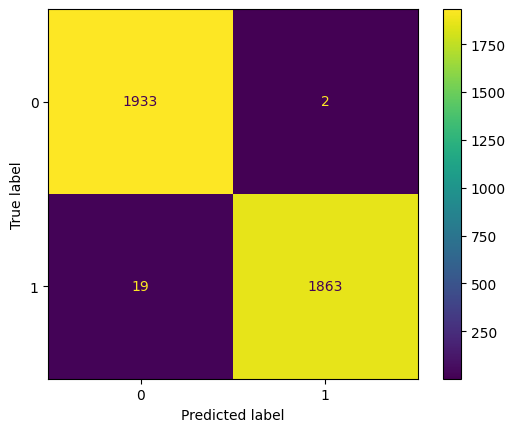

In [102]:
xgb_cm = confusion_matrix(y_val, y_pred_xgb)
xgb_cm_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=None)
xgb_cm_disp.plot()
plt.show()

In [103]:
print(classification_report(y_val, y_pred_xgb, target_names=['opinion', 'claim']))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1935
       claim       1.00      0.99      0.99      1882

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



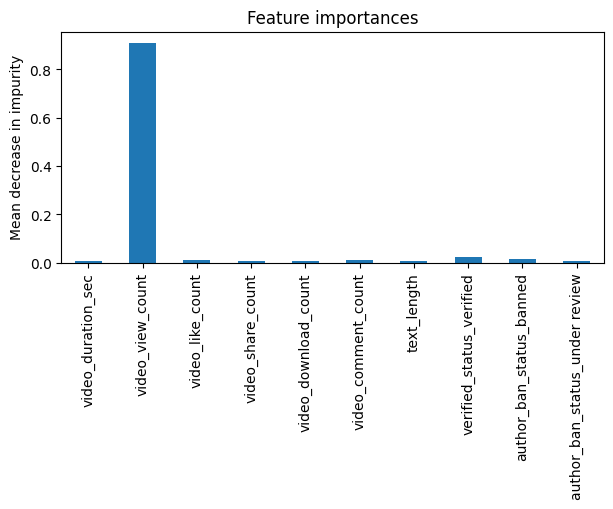

In [113]:
importances_xgb = xgb_cv.best_estimator_.feature_importances_
xgb_importances = pd.Series(importances_xgb, index=X_val.columns)

plt.figure(figsize=(7,3))
xgb_importances.plot.bar()
plt.title('Feature importances')
plt.ylabel('Mean decrease in impurity')
plt.show()

XGBoost Classifier Summary

The XGBoost classifier performed well on the validation set, delivering high accuracy and reliable claim detection.

- Claim Detection: The model correctly identified 1863 true claims, missing only 19 (~1%) false negatives. It made just 2 false positives, meaning a very small number of opinions were misclassified as claims. With a recall of 0.99, the model remains highly effective at capturing potentially harmful content.
- Overall Performance: Achieved an overall accuracy of 0.99, with precision, recall, and F1-scores for both classes reaching 0.99 or higher, indicating strong and balanced predictive power.
- Feature Importance: Similar to Random Forest, `video_view_count` was the most influential predictor by a large margin. Other features, including `video_like_count` and moderation-related statuses, had minimal impact - pointing to a reliance on video popularity in classification.

In [108]:
xgb_report = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_val, y_pred_xgb),
    'Precision': precision_score(y_val, y_pred_xgb),
    'Recall': recall_score(y_val, y_pred_xgb),
    'F1-Score': f1_score(y_val, y_pred_xgb)
}

models_results.append(xgb_report)
models_results_df = pd.DataFrame(models_results).round(5)
models_results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.99502,1.00000,0.9899,0.99493
1,XGBoost,0.99450,0.99893,0.9899,0.99440


## Best model prediction on test data

Model Selection: Why Random Forest?
Both Random Forest and XGBoost performed very well, but Random Forest was chosen as the final model because:
- It had no false positives, while XGBoost had 2.
- It achieved equally high recall (0.99) with slightly better precision.

Overall, Random Forest gave the most reliable results with less complexity.

In [109]:
y_pred = rfc_cv.best_estimator_.predict(X_test)

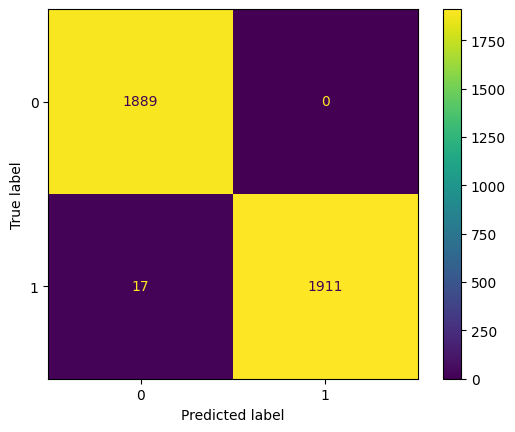

In [110]:
cm = confusion_matrix(y_test, y_pred)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
cm_disp.plot()
plt.show()

In [111]:
print(classification_report(y_test, y_pred, target_names=['opinion', 'claim']))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1889
       claim       1.00      0.99      1.00      1928

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



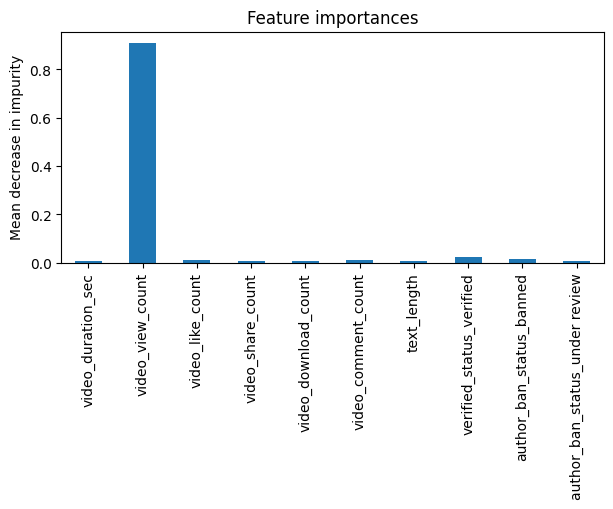

In [112]:
importances = rfc_cv.best_estimator_.feature_importances_
importances = pd.Series(importances, index=X_test.columns)

plt.figure(figsize=(7,3))
xgb_importances.plot.bar()
plt.title('Feature importances')
plt.ylabel('Mean decrease in impurity')
plt.show()

Final Evaluation on Test Set

The Random Forest model continued to perform exceptionally well on the test set, confirming its reliability.
- Claim Detection: The model correctly classified 1911 claims, missing only 17 (~0.9%). Importantly, it made no false positives — none of the opinions were incorrectly flagged as claims.
- Overall Performance: The model achieved accuracy, precision, recall, and F1-score of 1.00 or very close, showing strong generalization to unseen data.
- Feature Importance: As before, `video_view_count` remained the dominant predictor, while other features had minimal impact - indicating the model still relies mostly on video popularity.

## Saving the Model with pickle

In [118]:
with open('tiktok_rfc_model.pkl', 'wb') as f:
    pickle.dump(rfc_cv, f)

In [ ]:
# with open('tiktok_rfc_model.pkl', 'rb') as f:
#    model_loaded = pickle.load(f)